In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import random
import IPython
from scipy.io.wavfile import write
import wave

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2024-03-14 13:31:55--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   174MB/s    in 13s     

2024-03-14 13:32:09 (178 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
!mkdir /content/dataSet
!tar -xzvf speech_commands_v0.02.tar.gz -C /content/dataSet

mkdir: cannot create directory ‘/content/dataSet’: File exists
tar (child): speech_commands_v0.02.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
def count_wav_files(chemin):
    nb_fichier = 0
    for file_name in os.listdir(chemin):
        nb_fichier += 1

    return nb_fichier

nb_fichiers = count_wav_files("/content/dataSet/down")
print("Nombre de fichiers audio dans le dossier down:", nb_fichiers)

Nombre de fichiers audio dans le dossier down: 3917


In [ ]:
def silence_generator(nbFile, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i in range(nbFile):
        echantillons = np.random.random(16000) * 0.1  # Générer des échantillons aléatoires de longueur 1 seconde

        file_path = os.path.join(directory, f'silence_{i}.wav')

        with wave.open(file_path, 'w') as wf:
            wf.setnchannels(1)
            wf.setsampwidth(2)
            wf.setframerate(16000)
            wf.writeframes(echantillons.astype(np.int16))

output_directory = "/content/dataSet/silence"
silence_generator(nb_fichiers, output_directory)

In [ ]:
path = "/content/dataSet/silence/silence_1004.wav"

IPython.display.Audio(path)

In [ ]:
def get_audio_duration(file_path):
    # Charger le fichier audio
    audio, sr = librosa.load(file_path)

    # Calculer la durée de l'audio en secondes
    duration = librosa.get_duration(y=audio, sr=sr)

    return duration

# Chemin vers le fichier audio
file_path = "/content/dataSet/_background_noise_/doing_the_dishes.wav"

# Obtenir la durée de l'audio
duration = get_audio_duration(file_path)

# Afficher la durée
print(f"Durée de l'audio : {duration} secondes")

Durée de l'audio : 95.18312925170068 secondes


In [ ]:
def MFCC(path, number_mfcc):
    mfcc_list = []
    labels = []
    label = os.path.basename(os.path.normpath(path))

    for file in os.listdir(path)[:100]:
        if file.endswith('.wav'):

            audio_path = os.path.join(path, file)
            signal, sr = librosa.load(audio_path, sr=16000)
            duration = librosa.get_duration(y=signal, sr=sr)

            if duration < 1.0:
              pad_length = int((16000 * 1.0) - len(signal))
              pad_before = pad_length // 2
              pad_after = pad_length - pad_before

              signal = np.pad(signal, (pad_before, pad_after), mode='constant')

            if duration > 1.0:
              signal = signal[:16000]

            # Calcul des MFCC

            mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=number_mfcc,hop_length=143, center=False)
            mfcc_list.append(mfccs.T)
            labels.append(label)

    return mfcc_list,labels

In [ ]:
##mfccs , labels= MFCC('/content/dataSet/bed/', 40)
#print(mfccs[4].shape)

directory = '/content/dataSet/'

# Initialiser les listes pour stocker les MFCC et les labels
all_mfcc_list = []
all_labels = []

# Parcourir chaque dossier dans le répertoire
key_words = ['up', 'down', 'left', 'right', 'silence','_background_noise_']

# Parcourir chaque mot-clé
for key_word in key_words:
    folder_path = os.path.join(directory, key_word)
    # Vérifier si le dossier existe
    if os.path.exists(folder_path):
        # Pour chaque dossier, parcourir les fichiers audio WAV
        mfcc_list, labels = MFCC(folder_path, 40)
        all_mfcc_list.extend(mfcc_list)
        all_labels.extend(labels)
        print("Dossier traité: ", key_word)


Dossier traité:  up
Dossier traité:  down
Dossier traité:  left
Dossier traité:  right
Dossier traité:  silence
Dossier traité:  _background_noise_


In [ ]:
print("Dimensions des MFCC array:", all_mfcc_list[0].shape)
print("Dimensions des labels array:", len(all_labels))

Dimensions des MFCC array: (98, 40)
Dimensions des labels array: 506


# CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(20,8), stride=(1,3))
        self.maxpooling = nn.MaxPool2d(kernel_size=(1, 3),stride=(1,3))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(10,4), stride=(1,1))
        self.lin = nn.Linear(84,64)

        self.fc = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)


        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()
        self.Relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        #print("x shape1:",x.shape)
        x = self.maxpooling(self.Relu(self.conv1(x)))
        #print("x max:",x.shape)
        x = self.Relu(self.conv2(x))
        #print("x shape1:",x.shape)

        x = self.flatten(x)
        #print("x shape2:",x.shape)
        x = self.lin(x)
        #print("x shape3:",x.shape)
        x = self.dropout(x)

        x = self.fc(x)
        x = self.softmax(self.fc2(x))
        #print("x shape4:",x.shape)

        return x

model2 = CNN_2()

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

print(model2)

CNN_2(
  (conv1): Conv2d(1, 64, kernel_size=(20, 8), stride=(1, 3))
  (maxpooling): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(10, 4), stride=(1, 1))
  (lin): Linear(in_features=84, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (softmax): Softmax(dim=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Définir l'ensemble de données personnalisé (à adapter en fonction de votre propre ensemble de données)
class SpeechDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'input': self.data[idx], 'label': self.labels[idx]}
        return sample

In [ ]:
# Créer une instance du modèle
model = model2

# Définir l'optimiseur et la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Préparer les données (à adapter en fonction de votre propre ensemble de données)


train_data = all_mfcc_list
train_labels = all_labels

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (par exemple, 30% pour l'entraînement, 70% pour le test) mais on veut 80 20
train_data, test_data, train_labels, test_labels = train_test_split(all_mfcc_list, all_labels, test_size=0.2, random_state=42)

# Créer l'ensemble de données et les chargeurs de données pour l'entraînement et le test
train_dataset = SpeechDataset(train_data, train_labels)
test_dataset = SpeechDataset(test_data, test_labels)
print(train_labels)

batch_size = 1  # Définir la taille de lot souhaitée
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

['silence', 'up', 'right', 'silence', 'up', 'right', 'right', 'up', 'silence', 'silence', 'right', 'down', 'left', 'silence', 'down', 'up', 'silence', 'left', 'left', 'left', 'silence', 'down', 'up', 'right', 'right', 'down', 'down', 'left', 'down', 'right', 'up', 'down', 'down', 'silence', 'right', 'up', 'down', 'up', 'up', 'left', 'up', 'left', 'silence', 'up', 'down', 'silence', 'up', 'left', 'silence', 'silence', 'up', 'down', 'up', 'up', 'silence', 'right', 'up', 'silence', 'down', 'up', 'down', 'right', 'left', 'up', 'left', 'silence', 'up', 'up', 'silence', 'down', 'up', 'down', 'silence', 'down', 'down', 'down', 'down', 'left', 'down', 'right', 'right', 'right', 'left', 'left', 'silence', 'down', 'right', 'up', 'right', 'down', 'silence', 'right', 'silence', 'down', 'left', 'down', 'silence', 'down', 'up', 'down', 'left', 'right', 'up', 'left', 'down', 'down', 'down', 'left', 'up', 'right', 'silence', 'left', 'down', 'left', 'right', 'silence', 'right', 'silence', 'left', 'left

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
# Entraînement du modèle
label_to_int = {'up': 0, 'down': 1, 'left': 2, 'right': 3, '_background_noise_': 4,'silence': 5}

num_epochs = 10
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):

        inputs = batch['input']
        labels = torch.nn.functional.one_hot(labels, num_classes=6)
        #print(labels)
        labels = [label_to_int[label_str] for label_str in batch['label']]
        labels = torch.tensor(labels)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        #print("outputs shape", outputs.shape)
        #print("labels shape", labels)
        labels = labels.repeat(outputs.shape[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 4.121924877166748
Epoch [2/10], Loss: 4.139054775238037
Epoch [3/10], Loss: 3.7884373664855957
Epoch [4/10], Loss: 4.16235876083374
Epoch [5/10], Loss: 4.184349536895752
Epoch [6/10], Loss: 3.2080576419830322
Epoch [7/10], Loss: 4.184632301330566
Epoch [8/10], Loss: 4.184596538543701
Epoch [9/10], Loss: 4.176359176635742
Epoch [10/10], Loss: 4.177769184112549


In [ ]:
total_correct = 0
total_samples = 0
total_loss = 0

for batch_idx, batch in enumerate(test_loader):
    inputs = batch['input']
    labels = torch.nn.functional.one_hot(labels, num_classes=6)
    labels = [label_to_int[label_str] for label_str in batch['label']]
    labels = torch.tensor(labels)

    outputs = model(inputs.float())
    labels = labels.repeat(outputs.shape[0])

    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    total_loss += loss.item()

accuracy = total_correct / total_samples
average_loss = total_loss / len(test_loader)

print(f'Final Accuracy: {accuracy:.4f}, Final Loss: {average_loss:.4f}')


Final Accuracy: 0.2096, Final Loss: 3.9752


# Utilisation du log-spectrogramme à la place des MFCC

In [ ]:
def compute_log_spectrogram(audio_path, n_fft=2048, hop_length=512):
    # Chargement de l'audio
    labels = []
    signal, sr = librosa.load(audio_path, sr=None)

    if duration < 1.0:
              pad_length = int((16000 * 1.0) - len(signal))
              pad_before = pad_length // 2
              pad_after = pad_length - pad_before

              signal = np.pad(signal, (pad_before, pad_after), mode='constant')

    if duration > 1.0:
              signal = signal[:16000]

    # Calcul du spectrogramme
    spectrogram = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))

    # Appliquation d'une transformation logarithmique
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
     # Redimensionner le spectrogramme à une longueur de 32
    desired_length = 32
    if log_spectrogram.shape[1] < desired_length:
        # Padding si la longueur est inférieure à la longueur souhaitée
        log_spectrogram = np.pad(log_spectrogram, ((0, 0), (0, desired_length - log_spectrogram.shape[1])), mode='constant')
    else:
        # Troncature si la longueur est supérieure à la longueur souhaitée
        log_spectrogram = log_spectrogram[:, :desired_length]

    return log_spectrogram


log_spec_list = []
labels_spec = []
# Parcourir chaque mot-clé
for key_word in key_words:
    folder_path = os.path.join("/content/dataSet/", key_word)
    for file in os.listdir(folder_path)[:100]:
      if file.endswith('.wav'):
        audio_path = os.path.join(folder_path, file)
        log_spec = compute_log_spectrogram(audio_path)
        log_spec_list.append(log_spec)
        labels_spec.append(os.path.basename(folder_path))
    print("Dossier traité: ", key_word, len(log_spec_list), len(labels_spec))

Dossier traité:  up 100 100
Dossier traité:  down 200 200
Dossier traité:  left 300 300
Dossier traité:  right 400 400
Dossier traité:  silence 500 500
Dossier traité:  _background_noise_ 506 506


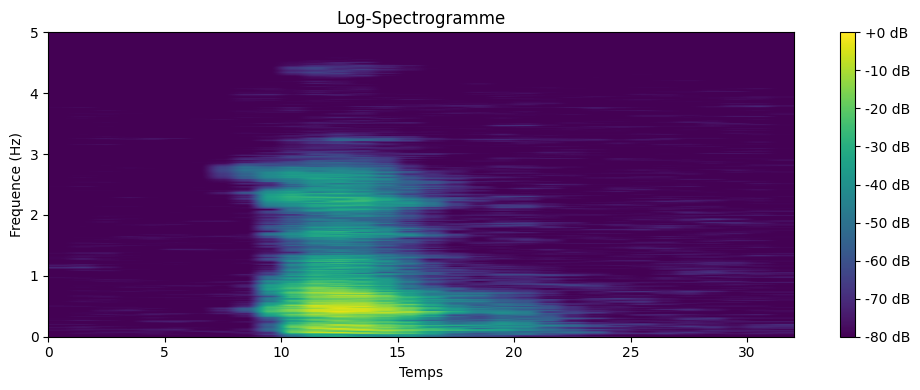

Forme d'un log spectrogramme: (1025, 32)


In [ ]:
#Affichage d'un log spectogramme
plt.figure(figsize=(10, 4))
plt.imshow(log_spec_list[0], aspect='auto', origin='lower', extent=[0, log_spec_list[0].shape[1], 0, 5])
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Spectrogramme')
plt.xlabel('Temps')
plt.ylabel('Frequence (Hz)')
plt.tight_layout()
plt.show()
print("Forme d'un log spectrogramme:",log_spec_list[0].shape)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_spectro(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN_spectro, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(20,8), stride=(1,3))
        self.maxpooling = nn.MaxPool2d(kernel_size=(1, 3),stride=(1,3))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(10,4), stride=(1,1))
        self.lin = nn.Linear(440,64)

        self.fc = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)


        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()
        self.Relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.maxpooling(self.Relu(self.conv1(x)))
        x = self.Relu(self.conv2(x))
        x = self.flatten(x)
        x = self.lin(x)
        x = self.dropout(x)

        x = self.fc(x)
        x = self.softmax(self.fc2(x))
        return x

cnnspectro = CNN_spectro()

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnspectro.parameters(), lr=0.001)

print(cnnspectro)

CNN_spectro(
  (conv1): Conv2d(1, 64, kernel_size=(20, 8), stride=(1, 3))
  (maxpooling): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(10, 4), stride=(1, 1))
  (lin): Linear(in_features=440, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (softmax): Softmax(dim=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Créer une instance du modèle
model = cnnspectro

# Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
class_to_id = {'silence': 0, 'up': 1, 'down': 2, 'left': 3, 'right': 4, '_background_noise_': 5}

# Convertir les labels en valeurs numériques
labels_spec = [class_to_id[label] for label in labels_spec]

train_data, test_data, train_labels, test_labels = train_test_split(log_spec_list, labels_spec, test_size=0.2, random_state=42)


train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entraînement du modèle
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.float())
        labels = labels.repeat(outputs.shape[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/10], Loss: 4.183905601501465
Epoch [2/10], Loss: 4.183311462402344
Epoch [3/10], Loss: 4.181153297424316
Epoch [4/10], Loss: 4.1845502853393555
Epoch [5/10], Loss: 3.9492623805999756
Epoch [6/10], Loss: 4.18480110168457
Epoch [7/10], Loss: 4.185286045074463
Epoch [8/10], Loss: 4.185125827789307
Epoch [9/10], Loss: 3.950617790222168
Epoch [10/10], Loss: 4.185342788696289


# DNN

In [ ]:
#Création DNN
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.hidden_layers = 3
        self.hidden_nodes = 40

        self.input_layer = nn.Linear(in_features=98, out_features=self.hidden_nodes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden_nodes, self.hidden_nodes),
                nn.ReLU(),
                nn.Dropout(p=0.5)
            ) for _ in range(self.hidden_layers - 1)
        ])

        self.output_layer = nn.Linear(self.hidden_nodes, 6)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.relu(self.input_layer(x))
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)

        return output

In [ ]:
# Définir un dictionnaire pour mapper les étiquettes de chaînes de caractères à des entiers
label_to_int = {'up': 0, 'down': 1, 'left': 2, 'right': 3, '_background_noise_': 4, 'silence': 5}

# Entraînement du modèle
model = DNN()

# Définir l'optimiseur et la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch['input']
        labels_str = batch['label']

        labels = [label_to_int[label_str] for label_str in labels_str]

        labels = torch.tensor(labels)
        labels = torch.nn.functional.one_hot(labels, num_classes=6)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

Epoch [1/10], Loss: 5.919791702402406
Epoch [2/10], Loss: 2.515122155815658
Epoch [3/10], Loss: 2.2713894051601096
Epoch [4/10], Loss: 1.8847015851204938
Epoch [5/10], Loss: 1.715966717367715
Epoch [6/10], Loss: 1.7060945433481496
Epoch [7/10], Loss: 1.693482379880872
Epoch [8/10], Loss: 1.6120449942674968
Epoch [9/10], Loss: 1.6802745712275553
Epoch [10/10], Loss: 1.6058851876618838
